# Introduction to NLP Fundamentals in Tensorflow

NLP has the goal of deriving information out of natural language (could be sequance or text speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5c1d6eb2-4244-198f-e6cf-0f57516519a1)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-04-11 18:54:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-11 18:54:21 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a textdataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster). 

See the originol source here: https://www.kaggle.com/c/nlp-getting-started


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data 
unzip_data("nlp_getting_started.zip")

--2022-04-11 18:54:26--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.04s   

2022-04-11 18:54:26 (13.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be use python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas.

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training samples
import random
random_index = random.randint(0, len(train_df)-5) # create random index not higher then the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print(f"---\n")

target: 1 (real disaster)
Text:
The only country claiming the moral high ground is the only one to have dropped atomic bombs. #Hiroshima #BanTheBomb
http://t.co/6G49ywwsQJ

---

target: 1 (real disaster)
Text:
70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b...  http://t.co/BS6XaqHsim

---

target: 1 (real disaster)
Text:
#Japan #Fukushima the most serious man made disaster in human history...  ÛÏa marker of radiation brain damageÛ http://t.co/Y3ZfqJsvpz

---

target: 0 (not real disaster)
Text:
#NoSurrender Results: Full Metal Mayhem World Title Match Bully Ray Taken Out A Career Comes To An End and More! http://t.co/XEHwmsH7Lv

---

target: 0 (not real disaster)
Text:
Things you CAN pick up from tozlet seat|: butt leprosy full-blown jerkface syndrome a lateral lisp &amp; toilet rickets.

---



### Splits data into training and validation sets

In [10]:

from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_splits to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of data for validation splits
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first thing you'll have to do before you can build a model is to convert your text into numbers.

There are few wat to do this , namely:
* Tokenization - direct mapping of a token (token could be character or word) to number
* Embedding - create a matrix of feature vector for each token (the size of a feature vector can be defined and this embedding can be learned)


### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create group of n-words?
                                    output_mode="int", # how to make token into number
                                    output_sequence_length=None) # how long do you want your sequence be?
                                    #pad_to_max_tokens=True)

In [16]:
len(train_sentences[0].split())

7

In [17]:
# Find the average number of tokens (words) in the training tweets?
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it 
sample_sentence = "Ther's flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  1, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training datasets and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"original text\n {random_sentence}\
        \n\n\vectorized version:")
text_vectorizer([random_sentence])

original text
 @heyot6 Im not home. I need to watch. [Screams]        

ectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  1,  32,  34, 153,   8, 162,   5, 135, 476,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creatre an Embedding using an embedding layer

To make our embedding we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocublary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each tokens gets represented by a vector 100 long
* `input_length` = the length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim = 128, # output shape
                             input_length=max_length) # how long is each input
embedding

In [24]:
# Get a random sentence from a training set
random_sentence = random.choice(train_sentences)
print(f"original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

original text:
 Escaping her captors was the 1st step. Now she must survive a deadly storm &amp; a wild-looking recluse.
BETRAYED
http://t.co/0Q040STkCV
#books        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00538734, -0.01537452, -0.02267593, ...,  0.02863303,
         -0.02297744,  0.02135524],
        [ 0.01605619, -0.01708664,  0.02406639, ..., -0.02937564,
         -0.02387585,  0.04982315],
        [-0.00176001, -0.04126098, -0.00860924, ..., -0.01932191,
         -0.01351576, -0.01192104],
        ...,
        [-0.00526613, -0.00094298,  0.03783171, ..., -0.04900259,
         -0.01012214, -0.02348968],
        [ 0.03947635, -0.00352781,  0.02952946, ...,  0.02192301,
         -0.0247046 ,  0.03874237],
        [ 0.02039229, -0.02166079,  0.00340702, ...,  0.03084182,
         -0.03013574,  0.03567882]]], dtype=float32)>

In [25]:
# Check out a single token embedding 
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00538734, -0.01537452, -0.02267593,  0.01593879,  0.02049277,
        -0.00565093, -0.03468977,  0.03919427,  0.02712871, -0.03234202,
        -0.0385376 ,  0.02059723, -0.03793045,  0.01233426, -0.00857222,
         0.047178  , -0.03088932,  0.04130497,  0.0460859 , -0.02365515,
         0.03644774,  0.03201107, -0.04357302, -0.04235381,  0.01083249,
        -0.04419677, -0.00729909,  0.022921  , -0.02277008, -0.01357728,
        -0.0376726 , -0.00990101,  0.0016932 ,  0.02280232, -0.02037936,
        -0.0126195 , -0.03709911, -0.03743632, -0.01619758,  0.0121585 ,
         0.03810063,  0.01861816, -0.0495432 ,  0.00802922,  0.03491391,
         0.01230733,  0.03737682, -0.04068135, -0.0083198 ,  0.03612575,
         0.04620739, -0.01927636, -0.03833958, -0.03249986,  0.00502905,
         0.03042415, -0.01460095,  0.0373611 ,  0.03301281, -0.02812681,
         0.01044431, -0.00146338,  0.0107698 , -0.04920084, -0.01185546,
  

## Modeling a test dataset (running a series of experiments)

Now we've got a way to turn our text sequence into numbers, its time to start a series of building a modelling experiments.

we'll start with baseline and move on from there.
* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-Forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standards steps in modelling with tensorflow.

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline
As with all machine learning modelling experiments, it's importent to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll ue sklearn Multinomial Naive Bayes using the TF-IDF formula to convert our words into numbers.

**Note:** It's common practise to use non-DL algorithms as a baseline because of thier speed and then latter using DL to see if you can improve them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokeinization and modelling pipelines
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # conver words into numbers
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our base model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"our baseline model achieve an accuracy of: {baseline_score*100:.2f}%")

our baseline model achieve an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evolution function for our model experiments

we could evaluate all our model's predictions with differnts metrics every time, however, this will be cumbersome and could easliy fixed with a function.

Let's create one to compare our predictions with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [29]:
# Function to evaluate: accuracy, precison, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of binary classification model.
  """
  # calculates model accuracy
  model_accuracy =  accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1-score": model_f1
  }
  return model_results

In [30]:
# Get baseline reuslts
baseline_results =  calculate_results(y_true = val_labels,
                                      y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [31]:
# Create a tensorbord callback (need to create a new for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model



In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history=model_1.fit(x=train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
            y=train_labels,
            epochs=5,
            validation_data= (val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220411-185432
Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.6135 - accuracy: 0.6935 - val_loss: 0.5369 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4413 - accuracy: 0.8178 - val_loss: 0.4740 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3476 - accuracy: 0.8586 - val_loss: 0.4584 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2847 - accuracy: 0.8901 - val_loss: 0.4637 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2378 - accuracy: 0.9137 - val_loss: 0.4816 - val_accuracy: 0.7835


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4816 - accuracy: 0.7835


[0.4816458821296692, 0.7834645509719849]

In [37]:
# Make some predictions and evaluate those 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [38]:
# look at single predictions
model_1_pred_probs[0]

array([0.30855557], dtype=float32)

In [39]:
# look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.30855557],
       [0.780856  ],
       [0.997895  ],
       [0.10031524],
       [0.11849025],
       [0.938868  ],
       [0.912509  ],
       [0.99300015],
       [0.9579597 ],
       [0.25975457]], dtype=float32)

In [40]:
# Convert model prediction probabilities to label format
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [41]:
# Calculate our model 1 results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1-score': 0.780037033211351,
 'precision': 0.7893369161898318,
 'recall': 0.7834645669291339}

In [42]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualize learned embeddings


In [43]:
# Get vocubalry from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [45]:
# Get the weight metrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow has incredible guide on word embedding themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [46]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
#import io
#out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
#out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

#for index, word in enumerate(words_in_vocab):
 # if index == 0:
  #  continue  # skip 0, it's padding.
  #vec = embed_weights[index]
  #out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  #out_m.write(word + "\n")
#out_v.close()
#out_m.close()

In [47]:
# Download files from colab to upload to projector
#try:
  #from google.colab import files
  #files.download('vectors.tsv')
 # files.download('metadata.tsv')
#except Exception:
  #pass

Download the file above we can visualize them using https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

**Resource:** If you would like to know more about embeddings, i'd encourge you to check out:

* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's word embeddings guide: https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Network (RNN's)

RNN'S are useful for sequence data.

The premise of recurrent neural network is to use the representation of the previous input to aid the represetation to later input.

**Resource:**If you want an overview of the internals of the recurrent neural network, see the following:
- MIT's sequence modelling lecture https://youtu.be/QvkQ1B3FBqA
- Chris Ola's intro to LSTMs https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karapthy's the unreasonable effeftivness of recurrent neural networks:http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cell)

Our structure of RNN typically look like this:

```
Input(text)-> Tokenize -> Embedding -> Layers(RNNs/dense) -> Output (label probability)
```

In [48]:
# Create a LSTM model 
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequence=True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [49]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [50]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [51]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220411-185444
Epoch 1/5
215/215 [==============================] - 7s 12ms/step - loss: 0.2220 - accuracy: 0.9223 - val_loss: 0.5550 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1580 - accuracy: 0.9406 - val_loss: 0.6118 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1291 - accuracy: 0.9515 - val_loss: 0.7008 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1079 - accuracy: 0.9606 - val_loss: 0.7261 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0865 - accuracy: 0.9682 - val_loss: 0.8629 - val_accuracy: 0.7730


In [52]:
# Make prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]        

array([[1.3195462e-02],
       [6.5639275e-01],
       [9.9978369e-01],
       [6.0091037e-02],
       [9.4889564e-04],
       [9.9790883e-01],
       [7.5357229e-01],
       [9.9987173e-01],
       [9.9976188e-01],
       [3.8915724e-01]], dtype=float32)

In [53]:
# Convert model 2 preds to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.29658792650919,
 'f1-score': 0.7696944315968833,
 'precision': 0.7774632689285239,
 'recall': 0.7729658792650919}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU 

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [56]:
# Build RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
# x= layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other,you need return_sequence=True
#print(x.shape)
#x = layers.LSTM(42, return_sequences=True)(x)
#print(x.shape)
#x = layers.GRU(99)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [57]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [58]:
 # Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220411-185500
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1567 - accuracy: 0.9375 - val_loss: 0.7055 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0839 - accuracy: 0.9696 - val_loss: 0.7962 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0671 - accuracy: 0.9733 - val_loss: 1.0293 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0576 - accuracy: 0.9764 - val_loss: 1.1088 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0535 - accuracy: 0.9780 - val_loss: 1.2792 - val_accuracy: 0.7703


In [60]:
# Make some prediction with our GRU model
model_3_pred_probs= model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.6469505e-02],
       [7.9679465e-01],
       [9.9992406e-01],
       [1.2502472e-01],
       [1.4683102e-04],
       [9.9990654e-01],
       [9.8817664e-01],
       [9.9996352e-01],
       [9.9993479e-01],
       [9.9257916e-01]], dtype=float32)

In [61]:
# Convert model 3 pred probs to label
model_3_preds =tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Caclulate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'f1-score': 0.769333028556703,
 'precision': 0.7702878929185921,
 'recall': 0.7703412073490814}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, a bidirectional RNN goes from right to left as well as left to right. 

In [63]:
# Build a bidirectional RNN in TensorFlow 
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x= layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [64]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [65]:
 # Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220411-185524
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.1061 - accuracy: 0.9680 - val_loss: 1.0191 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0521 - accuracy: 0.9791 - val_loss: 1.0999 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0469 - accuracy: 0.9785 - val_loss: 1.3186 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0409 - accuracy: 0.9799 - val_loss: 1.4694 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0410 - accuracy: 0.9813 - val_loss: 1.2115 - val_accuracy: 0.7677


In [67]:
# Make prediction with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[2.1805476e-02],
       [6.0673171e-01],
       [9.9989378e-01],
       [1.8903911e-01],
       [2.4022982e-05],
       [9.9287474e-01],
       [3.3721501e-01],
       [9.9996448e-01],
       [9.9991179e-01],
       [7.3868871e-01]], dtype=float32)

In [68]:
# Convert preds probs to labels 
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [69]:
# Calculate the results of bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.77165354330708,
 'f1-score': 0.7646846187166754,
 'precision': 0.7712255031085189,
 'recall': 0.7677165354330708}

## Convolution Neural Network for Text (and other type of sequences)

We've use CNN for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we're Conv2D for our image data but now we're going to use Conv1D.

The typicall structure of Conv1D model for sequence (in our case , text):

```
Input(text) -> Tokenization -> Embeddings -> Layers(s) (typically Conv1D + pooling) -> Outputs (class probabilities)

```

## Model 5: Conv1D

For different explanation of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D)
* Differnce between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=%22SAME%22%20%3A%20output%20size%20is,size%20shrinks%20by%20filter_size%20%2D%201%20.

In [70]:
# Test out our embedding layer , Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding (text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is alse refferd to as ngram of 5 (meaning it looks at 5 words at a time )
                        strides=1, # default
                        activation="relu",
                        padding="valid") # default="valid", the output is smaller then the input shape, "same" means output is same shape as input 
conv_1d_output = conv_1d(embedding_test)  # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equilvent "to get the most importent feature" or "get the feature with the highest value"
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape 


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [71]:
#embedding_test

In [72]:
# conv_1d_output

In [73]:
# max_pool_output

In [74]:
# Create 1 dimensional convolutional layers to model sequence
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x= layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5= tf.keras.Model(inputs, outputs, name="model_5_Conv1D")


 # Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [75]:
# Fit model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220411-185554
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1221 - accuracy: 0.9604 - val_loss: 0.9078 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0746 - accuracy: 0.9721 - val_loss: 1.0053 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0619 - accuracy: 0.9749 - val_loss: 1.1306 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0555 - accuracy: 0.9777 - val_loss: 1.1378 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0498 - accuracy: 0.9793 - val_loss: 1.1748 - val_accuracy: 0.7625


In [76]:
# Make prediction with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.0783922e-01],
       [9.5639658e-01],
       [9.9998283e-01],
       [4.3154608e-02],
       [5.6181655e-08],
       [9.9637920e-01],
       [9.6869510e-01],
       [9.9998224e-01],
       [9.9999928e-01],
       [9.1073161e-01]], dtype=float32)

In [77]:
# Conver model 5 pred probs to labels 
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
# Evaluate model 5 predictions
model_5_results=calculate_results(y_true=val_labels,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'f1-score': 0.7614244466786471,
 'precision': 0.762323768273959,
 'recall': 0.7624671916010499}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning and NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [79]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.03406017  0.02757177  0.04476143 -0.01796634  0.0231388   0.08824334
  0.04311017  0.03892512 -0.02749653  0.02421273  0.00119515 -0.0095571
 -0.00370347  0.03623484  0.00980565 -0.00676084  0.04504044 -0.0507359
 -0.01319189 -0.06042525  0.02039503  0.00943063 -0.02086579 -0.02760475
 -0.03828582 -0.06849557  0.04832792 -0.02567866 -0.03402455  0.00651371
 -0.06253951  0.05642124 -0.05882857  0.05297944  0.02598151 -0.07896736
  0.02661244  0.0425752  -0.03618455 -0.0910733  -0.00045324  0.00302636
 -0.04925039 -0.01367888 -0.10264204 -0.04099679 -0.01790166 -0.03508538
 -0.06134892  0.00963284], shape=(50,), dtype=float32)


In [80]:
embed_samples[0].shape

TensorShape([512])

In [87]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [88]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")                           
], name = "model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_6.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220411-193131
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.5007 - accuracy: 0.7924 - val_loss: 0.4520 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4141 - accuracy: 0.8173 - val_loss: 0.4388 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.4012 - accuracy: 0.8229 - val_loss: 0.4317 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 9s 41ms/step - loss: 0.3920 - accuracy: 0.8264 - val_loss: 0.4293 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.3863 - accuracy: 0.8281 - val_loss: 0.4282 - val_accuracy: 0.8136


In [90]:
# Make prediction with use TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17373385],
       [0.8054501 ],
       [0.9862125 ],
       [0.22575092],
       [0.7464972 ],
       [0.76753926],
       [0.9816201 ],
       [0.9796403 ],
       [0.9324766 ],
       [0.12307607]], dtype=float32)

In [91]:
# Convet prediction probabilites into labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Calculate model 6 perfomance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'f1-score': 0.8127090804256158,
 'precision': 0.8143409343082497,
 'recall': 0.8136482939632546}

In [93]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1-score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub pretrained USE but with 10% of training data 

Transfer learning really helps when you don't have a large dataset.

To see our model performs on a smaller dataset, let's replicate `model_6` expect we'll train it on 10% of the data.

In [119]:
# Note: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SET INTO TRAINING SET

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["text"].to_list()
#len(train_sentences_10_percent), len(train_labels_10_percent)

In [123]:
# Making a better dataset split(NO data leakage)
train_10_percent_split= int (0.1 * len(train_sentences))
train_sentences_10_percent=train_sentences[:train_10_percent_split]
train_labels_10_percent=train_labels[:train_10_percent_split]

In [124]:
# Check the number of each labels in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [97]:
# Check the number of targets in our subset of our data
train_10_percent["target"].value_counts()


0    413
1    348
Name: target, dtype: int64

To recreate a model as same as previous model you've created you can use the `tf.keras.models.clone_model()` method, see more: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [125]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")                           
], name = "model_7_USE")




In [126]:
# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()


Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [127]:
# Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220411-202050
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.5057 - accuracy: 0.7783 - val_loss: 0.4566 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4156 - accuracy: 0.8146 - val_loss: 0.4423 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4028 - accuracy: 0.8208 - val_loss: 0.4376 - val_accuracy: 0.8176
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3950 - accuracy: 0.8267 - val_loss: 0.4342 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3874 - accuracy: 0.8294 - val_loss: 0.4304 - val_accuracy: 0.8110


In [128]:
# Make prediction with model trained on 10% data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.18326329],
       [0.7766246 ],
       [0.98692465],
       [0.21043472],
       [0.7616209 ],
       [0.75068754],
       [0.9823858 ],
       [0.97543824],
       [0.9415353 ],
       [0.08913068]], dtype=float32)

In [129]:
# Convet prediction probabilites into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [130]:
# Calculate model 6 perfomance metrics
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 81.10236220472441,
 'f1-score': 0.8103106829956115,
 'precision': 0.8112313586372479,
 'recall': 0.8110236220472441}

In [131]:
model_6_results

{'accuracy': 81.36482939632546,
 'f1-score': 0.8127090804256158,
 'precision': 0.8143409343082497,
 'recall': 0.8136482939632546}

## Comparing performance of each of our models

In [134]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_sentence_encoder": model_6_results,
                                  "7_tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.789337,0.783465,0.780037
2_lstm,77.296588,0.777463,0.772966,0.769694
3_gru,77.034121,0.770288,0.770341,0.769333
4_bidirectional,76.771654,0.771226,0.767717,0.764685
5_conv1d,76.246719,0.762324,0.762467,0.761424
6_tf_hub_sentence_encoder,81.364829,0.814341,0.813648,0.812709
7_tf_hub_10_percent_data,81.102362,0.811231,0.811024,0.810311


In [136]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,0.007927,0.811139,0.792651,0.786219
1_simple_dense,0.007835,0.789337,0.783465,0.780037
2_lstm,0.007730,0.777463,0.772966,0.769694
3_gru,0.007703,0.770288,0.770341,0.769333
4_bidirectional,0.007677,0.771226,0.767717,0.764685
5_conv1d,0.007625,0.762324,0.762467,0.761424
6_tf_hub_sentence_encoder,0.008136,0.814341,0.813648,0.812709
7_tf_hub_10_percent_data,0.008110,0.811231,0.811024,0.810311


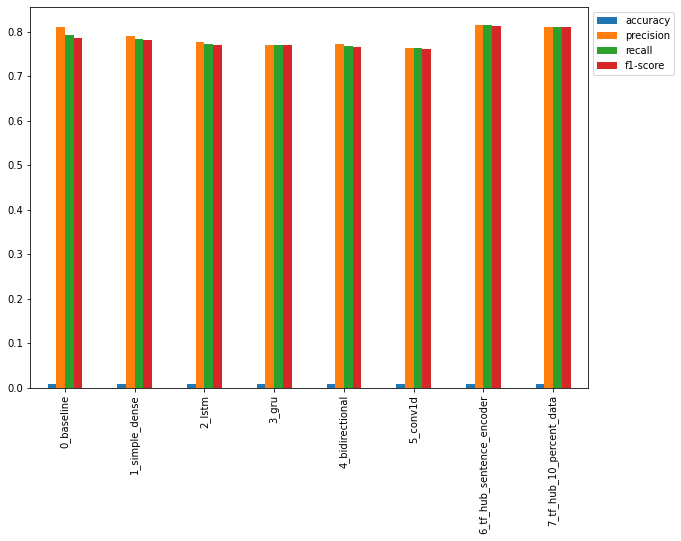

In [137]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


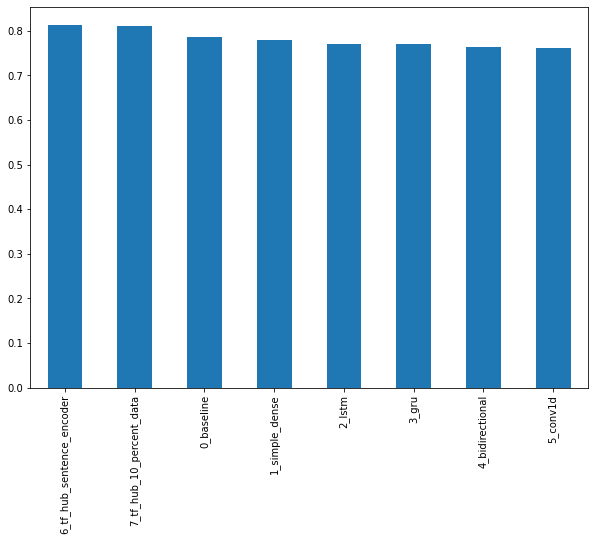

In [140]:
# Sort model results by f1-score
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7));

## Uploading our model trainig logs TensorBoard.dev

we can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
   
!tensorboard dev upload --logdir ./model_logs \
   --name "NLP modelling experiments" \
   --description "A series of different NLP modellings experiments with various models" \
   --one_shot # exits the uploader when upload has finished

The TensorBoard logs of the different modelling experiments we ran can be viewed here: https://tensorboard.dev/experiment/eyPqTq45Rz2Af4YfNrmgKA/#scalars

**Resource:** https://wandb.ai/site



In [144]:
# See the previous Tensorboard Dev experiments you've run...
#!tensorboard dev list

In [145]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id eyPqTq45Rz2Af4YfNrmgKA



## Saving and loading a train model

There are two main ways of saving a model in TensorFlow:

The HDF5 format.
The SavedModel format (default).

In [146]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [147]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [148]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)


24/24 [==============================] - 1s 27ms/step - loss: 0.4282 - accuracy: 0.8136


[0.42818087339401245, 0.8136482834815979]

Now lets save to the `SavedModel` format. https://www.tensorflow.org/tutorials/keras/save_and_load

In [149]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [150]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")


In [151]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)


24/24 [==============================] - 1s 27ms/step - loss: 0.4282 - accuracy: 0.8136


[0.42818087339401245, 0.8136482834815979]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
Which ones are the most wrong?
* And of these wrong examples which ond is it getting *most* wrong (those will prediction probabilities clsosest to the opposite class)

For Example if sample should have label 0 but our model predicts a prediction probability of 0.99 (really close to 1) and vice verse. 

In [162]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
unzip_data("08_model_6_USE_feature_extractor")

--2022-04-11 21:10:37--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 142.250.152.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip.6’

08_model_6_USE_feat 100%[===================>] 916.27M   220MB/s    in 4.2s    

2022-04-11 21:10:41 (216 MB/s) - ‘08_model_6_USE_feature_extractor.zip.6’ saved [960779165/960779165]



FileNotFoundError: ignored

In [163]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()


,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.173734
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.805450
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986212
3,@camilacabello97 Internally and externally scr...,1,0.0,0.225751
4,Radiation emergency #preparedness starts with ...,1,1.0,0.746497


In [164]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.935403
759,FedEx will no longer transport bioterror patho...,0,1.0,0.893065
628,@noah_anyname That's where the concentration c...,0,1.0,0.877520
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.839320
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.837925
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.827507
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.816451
474,My phone looks like it was in a car ship airpl...,0,1.0,0.813027
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.809481
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.805450


A reminder:

* 0 = Not a real diaster Tweet
* 1 = Real diaster Tweet

In [165]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9354034066200256
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8930649161338806
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8775200247764587
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8393204212188721
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8379251956939697
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Prob: 0.8275073766708374
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... 

In [166]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 1, Pred: 0, Prob: 0.07346857339143753
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.07101950794458389
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.06710036098957062
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

----

Target: 1, Pred: 0, Prob: 0.0667400136590004
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.060325395315885544
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.05248290300369263
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.051040131598711014
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!

## Making prediction on the test dataset

In [167]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.1152484193444252
Text:
@JagexSupport can u remove the email of the hijacker pls !! YKJL is my ign. i need to recover but pls block so they dont break bank pin!

----

Pred: 0, Prob: 0.09051632881164551
Text:
@TokyoDotCom I didn't either till it blew up my mentions lol

----

Pred: 1, Prob: 0.776198148727417
Text:
idgaf fly into a volcano

----

Pred: 0, Prob: 0.4352971613407135
Text:
Wolverine Fire Update - Thursday August 6 - 9:00 Am

Incident: Wolverine Fire Wildfire
Released: 41 min. ago... http://t.co/8WDTTzpTXH

----

Pred: 1, Prob: 0.9364690780639648
Text:
#Sismo DETECTADO #JapÌ_n [Report 6] 01:02:42 Okinawa Island region M3.8 Depth 10km Maximum seismic intensity 3 JST #??

----

Pred: 1, Prob: 0.8437672257423401
Text:
Anti-fracking group seeks review over #Lancashire seismic monitoring:
 
http://t.co/ZzbqmGNUsl #fracking http://t.co/Y23Xzl3fZv

----

Pred: 0, Prob: 0.0711340457201004
Text:
IGN: A Warcraft 3-inspired mode is likely coming to Heroes of the Storm h

## The speed/score tradeoff

In [168]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred


In [169]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred


(0.48936612800025614, 0.0006422127664045356)

In [170]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred


(0.03686660300081712, 4.838136876747654e-05)

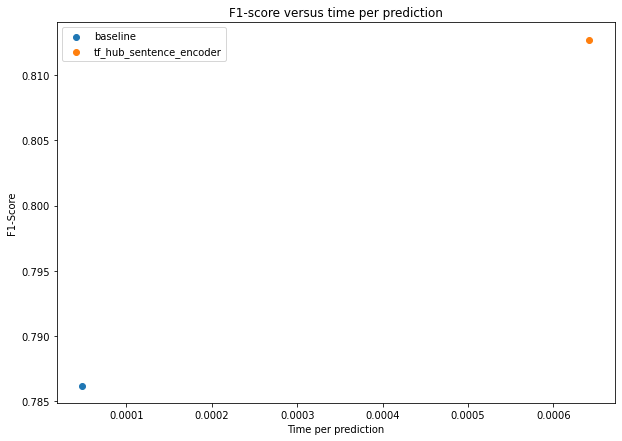

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1-score"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1-score"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");